In [1]:
import vizdoom as vzd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
possible_actions = np.zeros((8,6),dtype=int).tolist()
possible_actions[0] = [1,0,0,0,0]
possible_actions[1] = [0,1,0,0,0]
possible_actions[2] = [0,0,-45,0,0]
possible_actions[3] = [0,0,45,0,0]
possible_actions[4] = [0,0,0,50,0]
possible_actions[5] = [0,0,0,-50,0]
possible_actions[6] = [0,0,0,0,30]
possible_actions[7] = [0,0,0,0,-30]
possible_actions

[[1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, -45, 0, 0],
 [0, 0, 45, 0, 0],
 [0, 0, 0, 50, 0],
 [0, 0, 0, -50, 0],
 [0, 0, 0, 0, 30],
 [0, 0, 0, 0, -30]]

In [3]:
def color_transform(raw_map: np.array):
    map = raw_map.copy()
    
    # Create mask for gray colors (where all RGB values are similar)
    gray_mask = (abs(raw_map[:,:,0] - raw_map[:,:,1]) < 10) & (abs(raw_map[:,:,1] - raw_map[:,:,2]) < 10)
    
    # Create mask for dark brown colors (where R value is low)
    dark_brown_mask = (raw_map[:,:,0] < 100) & (raw_map[:,:,1] < 80) & (raw_map[:,:,2] < 60)
    
    # Set dark browns and grays to black
    map[gray_mask | dark_brown_mask] = [0, 0, 0]
    
    # Set everything else (background browns) to white
    map[~(gray_mask | dark_brown_mask)] = [255, 255, 255]
    
    # Keep the red marker if needed
    #map[118:121,158:161,:] = [255,0,0]
    
    return map


In [4]:
def tracing(raw_map: np.array):
    # Create a copy and get center coordinates
    map = raw_map.copy()
    center_y, center_x = 119, 159
    
    # Pre-allocate result array
    result = np.full_like(map, 255)
    
    # Get wall coordinates in upper half
    wall_coords = np.where((map[:center_y] != [255,255,255]).all(axis=2))
    
    # Vectorized direction calculations
    dx = wall_coords[1] - center_x 
    dy = wall_coords[0] - center_y
    distances = np.sqrt(dx*dx + dy*dy).astype(int)
    steps = np.maximum(distances * 2, 1)
    
    # Process each wall point
    for i in range(len(wall_coords[0])):
        y, x = wall_coords[0][i], wall_coords[1][i]
        
        # Calculate ray steps
        step_x = dx[i] / steps[i]
        step_y = dy[i] / steps[i]
        
        # Ray positions
        ray_x = center_x + np.arange(steps[i]) * step_x
        ray_y = center_y + np.arange(steps[i]) * step_y
        
        # Round to integer coordinates
        check_x = np.round(ray_x).astype(int)
        check_y = np.round(ray_y).astype(int)
        
        # Check if ray hits any walls
        is_visible = True
        for j in range(steps[i]):
            if (check_y[j], check_x[j]) != (y,x) and np.all(map[check_y[j], check_x[j]] == [0,0,0]):
                is_visible = False
                break
                
        result[y,x] = [0,0,0] if is_visible else [255,255,255]
    
    # Add red marker
    result[118:121, 158:161] = [255,0,0]
    
    return result

In [5]:
# duration 4 tics
def get_pictures(game: vzd.DoomGame):
    state = game.get_state()    
    st = state.screen_buffer.transpose(1,2,0)
    img = np.array([st])
    dph = np.array([state.depth_buffer])
    # turn left
    game.make_action(possible_actions[2])
    state = game.get_state()
    st = state.screen_buffer.transpose(1,2,0)
    img = np.append(img, [st], axis=0)
    dm = state.automap_buffer.transpose(1,2,0)
    debug_map = np.array([dm])
    dph = np.append(dph, [state.depth_buffer], axis=0)
    # turn right
    game.make_action(possible_actions[3],2)
    state = game.get_state()
    st = state.screen_buffer.transpose(1,2,0)
    img = np.append(img, [st], axis=0)
    dm = state.automap_buffer.transpose(1,2,0)
    debug_map = np.append(debug_map, [dm], axis=0)
    dph = np.append(dph, [state.depth_buffer], axis=0)
    # return to center
    game.make_action(possible_actions[2])
    state = game.get_state()
    dm = state.automap_buffer.transpose(1,2,0)
    debug_map = np.append(debug_map, [dm], axis=0)
    #dph = np.append(dph, [state.depth_buffer], axis=0)
    auto_map = state.automap_buffer.transpose(1,2,0)
    colortransformed_map = color_transform(auto_map)
    processed_map = tracing(colortransformed_map)
    return img, auto_map, processed_map, debug_map, dph

In [6]:
possible_actions

[[1, 0, 0, 0, 0],
 [0, 1, 0, 0, 0],
 [0, 0, -45, 0, 0],
 [0, 0, 45, 0, 0],
 [0, 0, 0, 50, 0],
 [0, 0, 0, -50, 0],
 [0, 0, 0, 0, 30],
 [0, 0, 0, 0, -30]]

In [7]:
actions_indices = [(4,2,4),(4,3,4),(5,2,5),(5,3,5),(6,2,6),(6,3,6),(7,2,7),(7,3,7),(4,2,6),(4,3,7)]

In [72]:
from matplotlib import pyplot as plt
import multiprocessing as mp
from functools import partial

def process_map(map_index, game_config='resources/temp_maps/datagen.cfg', scenario_path='data/maps_1key_noaug/30x30.wad'):
    game = vzd.DoomGame()
    game.load_config(game_config)
    game.set_doom_scenario_path(scenario_path)
    game.set_automap_mode(vzd.AutomapMode.WHOLE)
    game.set_render_hud(False)
    game.set_objects_info_enabled(True)
    game.set_labels_buffer_enabled(True)
    
    game.set_doom_map(f'map0{map_index+1}' if map_index<9 else f'map{map_index+1}')
    
    # Track previous positions
    prev_positions = []
    map_images = []
    map_maps = []
    map_positions = []
    map_depth = []
    
    for j in range(10):
        game.init()
        
        # Keep trying until we get a valid position
        while True:
            game.new_episode()
            if game.is_episode_finished():
                game.new_episode()
            
            state = game.get_state()
            st = state.screen_buffer.transpose(1,2,0)
            img = np.array([st])
            am = state.automap_buffer.transpose(1,2,0)
            dph = np.array([state.depth_buffer])
            
            tmp_img, auto_map, tmp_processed_map, debug_map, dph = get_pictures(game)
            tmp_position = state.game_variables
            
            # Check if position is too close to any previous position
            curr_x, curr_y = tmp_position[0], tmp_position[1]
            should_restart = False
            for prev_x, prev_y in prev_positions:
                if abs(curr_x - prev_x) < 100 and abs(curr_y - prev_y) < 100:
                    should_restart = True
                    break
                    
            if not should_restart:  # Only proceed if position is valid
                break
                
        prev_positions.append((curr_x, curr_y))
        
        temp_objects = state.objects
        inner_objects = [{'x': obj.position_x, 'y': obj.position_y, 'z': obj.position_z, 'angle': obj.angle} for obj in temp_objects if obj.name == 'RedCard']
        
        map_images.append(np.array([tmp_img]))
        map_maps.append(np.array([tmp_processed_map]))
        map_positions.append(np.array([tmp_position]))
        map_depth.append(np.array([dph]))
        
        game.close()
        
    print(f'map{map_index+1} done')
    return map_images, map_maps, map_positions, map_depth, inner_objects

# Set up parallel processing
num_processes = mp.cpu_count() - 1  # Leave one CPU free
pool = mp.Pool(processes=num_processes)

# Process maps in parallel
results = pool.map(process_map, range(100))

# Close the pool
pool.close()
pool.join()

# Combine results
images = np.array([result[0] for result in results])
maps = np.array([result[1] for result in results]) 
positions = np.array([result[2] for result in results])
depth = np.array([result[3] for result in results])
objects = np.array([result[4] for result in results])

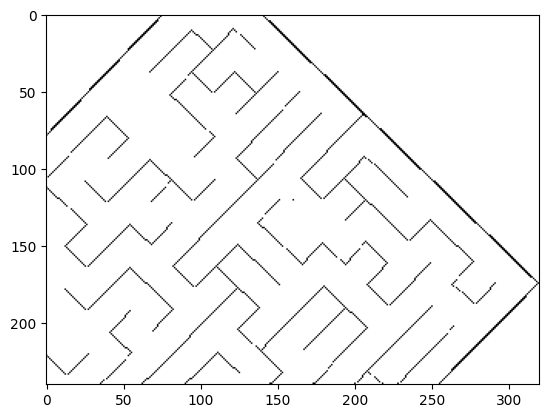

In [47]:
plt.imshow(color_transform(am))
m = color_transform(am)

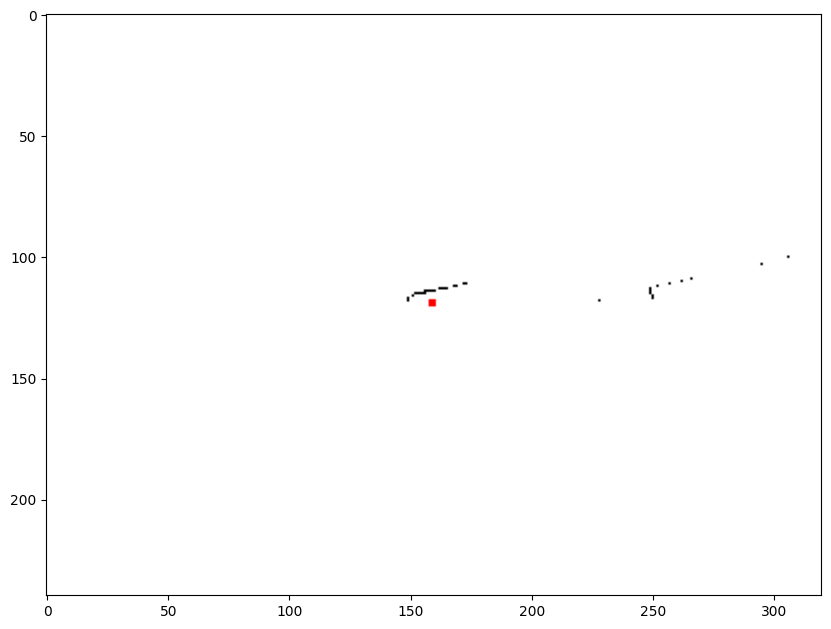

In [39]:
plt.figure(figsize=(10,10))
plt.imshow(tracing(m))
plt.show()


In [146]:
temp_copy_images = images.copy()
temp_copy_maps = maps.copy()
temp_copy_positions = positions.copy()
temp_copy_depth = depth.copy()
temp_copy_objects = objects.copy()


In [148]:
positions_list = [{'x': pos[0], 'y': pos[1], 'z': pos[2], 'angle': pos[3]} for pos in positions]
np.savez('data/99maps_data.npz', images=temp_copy_images, maps=temp_copy_maps, positions=temp_copy_positions,depth=temp_copy_depth,objects=temp_copy_objects)

In [150]:
# Load the data from 99maps_data.npz
#data = np.load('data/99maps_data.npz')
#maps = data['maps']
#images = data['images'] 
#positions = data['positions']
#depth = data['depth']
#objects = data['objects']

# Get dimensions
n_maps = 99
samples_per_map = maps.shape[0] // n_maps

# Split data into 99 parts
maps_split = np.array_split(maps, n_maps)
images_split = np.array_split(images, n_maps) 
positions_split = np.array_split(positions, n_maps)
depth_split = np.array_split(depth, n_maps)

# Save each split as separate file
for i in range(n_maps):
    np.savez(f'data/maps/map{i+1}_data.npz',
             maps=maps_split[i],
             images=images_split[i],
             positions=positions_split[i],
             depth=depth_split[i],
             objects=objects[i])


ValueError: Object arrays cannot be loaded when allow_pickle=False

In [48]:
images.shape,maps.shape,positions.shape,depth.shape,objects.shape

((10, 1, 3, 240, 320, 3),
 (10, 1, 240, 320, 3),
 (10, 1, 4),
 (10, 1, 3, 240, 320),
 (1, 1))

In [13]:
data = np.load('data/mywayhome_data.npz')
d1 = data['maps']
d2 = data['images']
d3 = data['positions']
#positions_list = [{'x': pos[0], 'y': pos[1], 'z': pos[2], 'angle': pos[3]} for pos in d3]
[print(f'x={a['x']}, y={a['y']}, z={a['z']}, angle={a['angle']}') for a in positions_list]



x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=686.64599609375, y=-62.38200378417969, z=0.0, angle=109.73144533804884
x=1039.3280029296875, y=-169.88400268554688, z=0.0, angle=285.8917236993768
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=460.3260040283203, y=-596.1199951171875, z=0.0, angle=184.41101078512403
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x=464.09800720214844, y=-60.496002197265625, z=0.0, angle=13.37036133123803
x=460.3260040283203, y=-596.1199951171875, z=0.0, angle=117.81188967586772
x=464.0, y=-176.0, z=0.0, angle=354.4024659028282
x=464.0, y=-176.0, z=0.0, angle=221.5008545437597
x=460.3260040283203, y=56.436004638671875, z=0.0, angle=147.35412601087106
x=686.8300018310547, y=-173.2469940185547, z=0.0, angle=120.9265137000304
x=1043.1000061035156, y=60.20799255371094, z=0.0, angle=13.886718753233254
x

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [65]:
positions.shape
positions_list = [{'x': pos[0,0], 'y': pos[0,1], 'z': pos[0,2], 'angle': pos[0,3]} for pos in positions]
positions_list

[{'x': np.float64(1083.3335571289062),
  'y': np.float64(1495.9386138916016),
  'z': np.float64(0.0),
  'angle': np.float64(293.52172858396585)},
 {'x': np.float64(2326.2337341308594),
  'y': np.float64(1094.5468292236328),
  'z': np.float64(0.0),
  'angle': np.float64(322.3498535906779)},
 {'x': np.float64(516.0163269042969),
  'y': np.float64(1444.1015625),
  'z': np.float64(0.0),
  'angle': np.float64(60.68298341256636)},
 {'x': np.float64(2774.2254638671875),
  'y': np.float64(878.5070343017578),
  'z': np.float64(0.0),
  'angle': np.float64(69.53247071931429)},
 {'x': np.float64(1094.1128234863281),
  'y': np.float64(1709.1121063232422),
  'z': np.float64(0.0),
  'angle': np.float64(221.68762212192817)},
 {'x': np.float64(1846.731201171875),
  'y': np.float64(208.42787170410156),
  'z': np.float64(0.0),
  'angle': np.float64(250.90026861310477)},
 {'x': np.float64(1509.279556274414),
  'y': np.float64(2080.698715209961),
  'z': np.float64(0.0),
  'angle': np.float64(349.3212891438

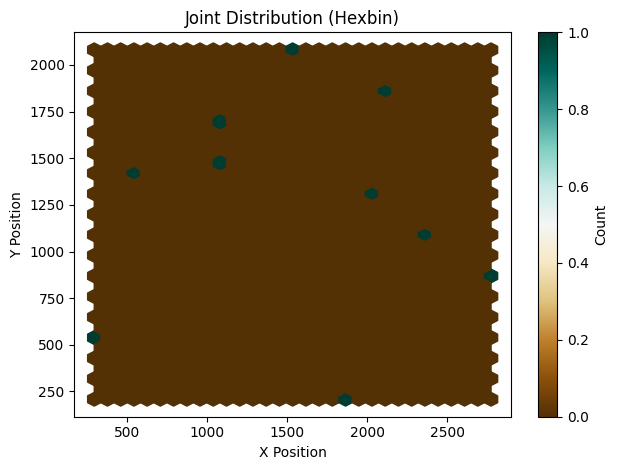

In [69]:
# Extract x and y coordinates from positions_list
x_coords = [pos['x'] for pos in positions_list]
y_coords = [pos['y'] for pos in positions_list]


# Create joint distribution plot using hexbin
plt.hexbin(x_coords, y_coords, gridsize=30, cmap='BrBG')
plt.title('Joint Distribution (Hexbin)')
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.colorbar(label='Count')

plt.tight_layout()
plt.show()

